Copyright (c) 2025 Mitsuru Ohno  
Use of this source code is governed by a BSD-3-style  
license that can be found in the LICENSE file.  

## 当ノートブックのワークフロー  
1. csvに書き込んだ反応式を読み込む。ただし速度定数はすべて既知とする  
2. 化学種ごとの微分型の反応速度式を作成する  
3. 作成した微分方程式を、数値解析可能な形式にする  
4. 化学種ごとの濃度の経時変化を求める  
5. 経時変化を図示する  

## 使用方法の要約
基本的な使用: RxnIVPsolv("sample_data.csv")でインスタンス化  
数値積分: get_ode_system()で必要なオブジェクトを取得  
エラーハンドリング: try-except文でエラーをキャッチ  
可視化: matplotlibで結果をプロット  
パラメータ解析: 異なる初期条件での比較  
これらの使用例は、現在のコードが正しく動作することを前提としています。もしエラーが発生した場合は、debug_ode_system()メソッドで詳細な情報を確認できます。  

## 反応式を記載したcsvファイルを指定する  

In [1]:
file_path = '../sample_data/sample_rxn_3a.csv'  # CSVファイルのパスを指定

In [2]:
# development phase
# Add the parent directory (one level up from the notebook's location) to the Python path
import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..'))

## 反応速度式をscipy.integrate.solve_ivpで処理できる連立微分方程式にする  

In [3]:
from dataclasses import dataclass, field
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from src.rxnfit.build_ode import RxnODEbuild
from src.rxnfit.solv_ode import SolverConfig, RxnODEsolver
from src.rxnfit.expdata_reader import expdata_read

In [4]:
builded_rxnode = RxnODEbuild(file_path)

In [5]:
builded_rxnode.get_ode_info(debug_info=True)

number of species: 5
unique species: ['ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
rate constant: {'k1': 0.078, 'k2': 0.191, 'k3': 0.201}

=== debug info ===
Successfully created function for ClCH2COOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for ClCH2COOOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
order of args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
system of ODE: {'ClCH2COOH': '-k1*ClCH2COOH(t)*H2O(t)+k2*ClCH2COOOH(t)', 'H2O': '-k1*ClCH2COOH(t)*H2O(t)+k1*ClCH2COOH(t)*H2O(t)+k3*H2O2(t)', 'ClCH2COOOH': 'k1*ClCH2COOH(t)*H2O(t)-k2*ClCH2COOOH(t)', 'O2': '0.5*k2*ClCH2COOOH(t)+0.5*k3*H2O2(t)',

In [6]:
builded_rxnode.rate_consts_dict

{'k1': 0.078, 'k2': 0.191, 'k3': 0.201}

## 数値積分を実行する  

In [7]:
# get_ode_infoの出力を参照して、初期値等の入力項目を渡す
config = SolverConfig(
    y0 = [2.945, 6.807, 0, 13.99, 0], # 初期濃度（必須）
    t_span=(0, 31),         # 時間範囲（必須）
    # t_eval: Optional[np.ndarray] = field(default=None),  # 任意
    method = "RK45",  # 任意
    rtol = 1e-6,    # 任意    
)

In [8]:
# 基本的な数値積分 -インスタンス化-
solved_rxnode = RxnODEsolver(builded_rxnode, config)

In [9]:
ode_construct, sol = solved_rxnode.solve_system()

Successfully created function for ClCH2COOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for ClCH2COOOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']


## 実験データを読み込む  

In [10]:
file_path_data = '../sample_data/sample_timecourse_3a.csv' # データファイルのパス
df1 = pd.read_csv(file_path_data)

expdata_read([df1,])  # 複数データフレームのリストを渡すとまとめて読み込み可能

[([array([ 0,  1,  4,  9, 13, 18, 22, 25, 28, 31]),
   array([ 0,  1,  4,  9, 13, 18, 22, 25, 28, 31]),
   array([ 0,  1,  4,  9, 13, 18, 22, 25, 28, 31]),
   array([ 0,  1,  4,  9, 13, 18, 22, 25, 28, 31]),
   array([ 0,  1,  4,  9, 13, 18, 22, 25, 28, 31])],
  [array([2.945, 2.852, 2.477, 2.07 , 1.762, 1.356, 1.106, 0.88 , 0.707,
          0.557]),
   array([6.807, 6.614, 6.422, 6.515, 6.569, 6.638, 6.642, 6.697, 6.721,
          6.743]),
   array([0.   , 0.193, 0.385, 0.292, 0.238, 0.169, 0.11 , 0.086, 0.065,
          0.063]),
   array([13.99 , 14.083, 14.458, 14.867, 15.187, 15.557, 15.875, 16.041,
          16.205, 16.374]),
   array([0.    , 0.    , 0.0415, 0.2925, 0.4795, 0.699 , 0.86  , 0.9705,
          1.0645, 1.155 ])])]


=== Time-course plot ===


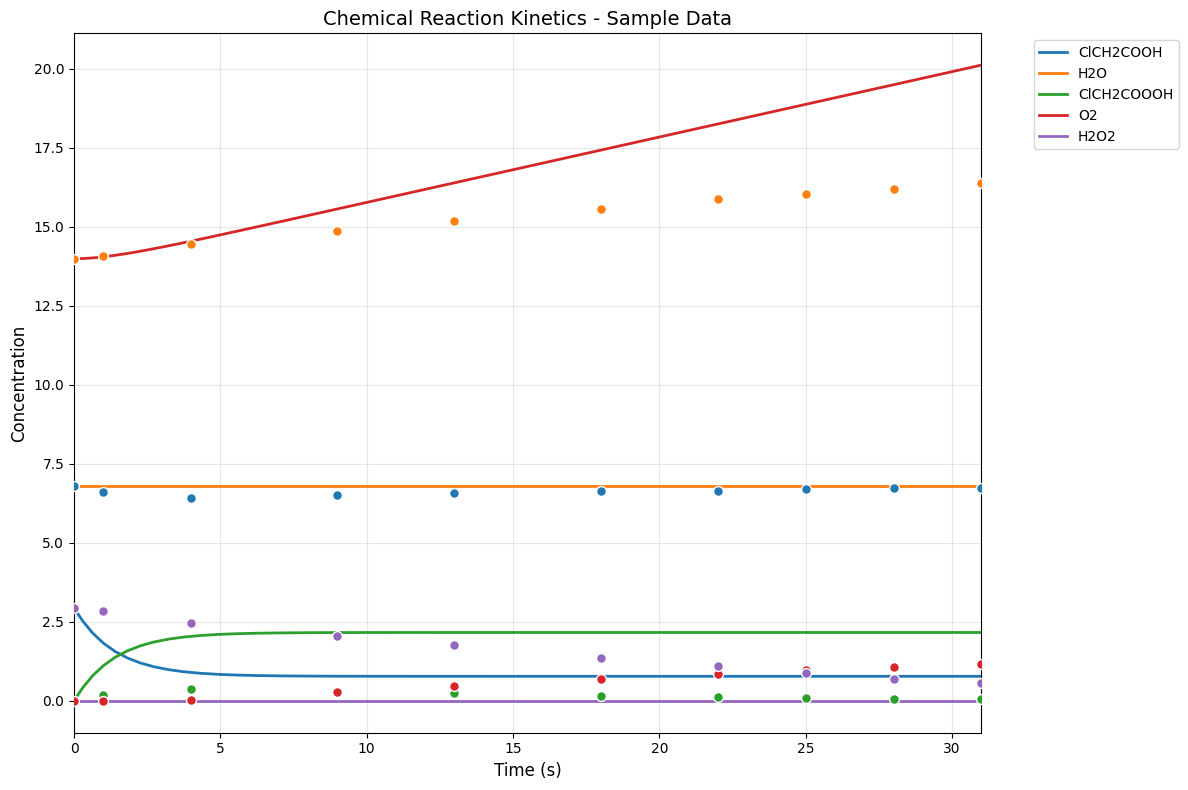


=== Concentration at the final time point ===
ClCH2COOH: 0.779138
H2O: 6.807000
ClCH2COOOH: 2.165862
O2: 20.115534
H2O2: 0.000000


In [11]:
solved_rxnode.solution_plot(expdata_df=df1)